## Data Mining of Solar Flares

The Data provided is from the Reuven Ramaty High Energy Solar Spectroscopic Imager (RHESSI, originally High Energy Solar Spectroscopic Imager or HESSI). It is a NASA solar flare observatory. <br>
Description and analysis of the data is in the report, here is manipulation of data in various forms filtering,cleaning, and transforming the data as appropriate such that it can be used to produce optimal classification for the flare bassed on its energy oputput, in the form of MLP and RF classifiers.


In [1]:
# Imports
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sklearn
import scikitplot as skplt

from sklearn.model_selection import train_test_split
# Import Model Classifiers.
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
# Import evaluation libaries.
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# Data preperation
### Data ingestion.

In [25]:
date_cols = ['start.date'] # https://stackoverflow.com/questions/21269399/datetime-dtypes-in-pandas-read-csv
df_rhessi_orig = pd.read_csv('../Data Sets/V1 Solar Flares from RHESSI Mission/hessi.solar.flare.2002to2016.csv', parse_dates=date_cols) # Read the original data in.
df_rhessi = df_rhessi_orig.copy() # Create a copy to work with.
print(type(df_rhessi)) # Check it's in the expected DataFrame format.

<class 'pandas.core.frame.DataFrame'>


### Initial inspection of the data.

In [26]:
df_rhessi.head(10) # Making sure the data has been injested correctly.

,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN
1,2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN
2,2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN
3,2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN
4,2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2
5,2021353,2002-02-13,07:07:48,07:09:14,07:20:56,788,272,524304,12-25,-271,389,474,9825,A1,P1,NaN,NaN,NaN
6,2021354,2002-02-13,07:20:56,07:22:42,07:30:04,548,28,52488,6-12,-267,390,473,9825,A1,P1,NaN,NaN,NaN
7,2021312,2002-02-13,08:53:20,08:55:18,09:05:08,708,92,125352,25-50,-362,309,476,0,A1,P1,NaN,NaN,NaN
8,2021339,2002-02-13,10:02:56,10:04:42,10:04:44,108,26,10368,6-12,-235,390,455,9822,A1,P1,PE,Q2,SE
9,2021313,2002-02-13,12:29:32,12:30:58,12:33:24,232,26,16920,12-25,-905,-375,980,0,A1,P1,NaN,NaN,NaN



### Look at the data types of each column/attribute.

In [27]:
# They do not match the briefe, this will need to be rectified later. 
# IPSI and Contra should be of type int.
df_rhessi.dtypes

flare                        int64
start.date          datetime64[ns]
start.time                  object
peak                        object
end                         object
duration.s                   int64
peak.c/s                     int64
total.counts                 int64
energy.kev                  object
x.pos.asec                   int64
y.pos.asec                   int64
radial                       int64
active.region.ar             int64
flag.1                      object
flag.2                      object
flag.3                      object
flag.4                      object
flag.5                      object
dtype: object

### Inspect the Unique values of the categorical (dtype object), attributes.

In [15]:
# Create a new df_uniques and read in the columns unique values.
df_uniques = pd.DataFrame(columns= ['energykev', 'flag1', 'flag2', 'flag3', 'flag4', 'flag5'])
df_uniques.energykev = pd.Series(df_rhessi['energy.kev'].unique())
df_uniques.flag1 = pd.Series(df_rhessi["flag.1"].unique())
df_uniques.flag2 = pd.Series(df_rhessi['flag.2'].unique())
df_uniques.flag3 = pd.Series(df_rhessi['flag.3'].unique())
df_uniques.flag4 = pd.Series(df_rhessi['flag.4'].unique())
df_uniques.flag5 = pd.Series(df_rhessi['flag.5'].unique())
df_uniques

,energykev,flag1,flag2,flag3,flag4,flag5
0,12-25,A1,P1,NaN,NaN,NaN
1,6-12,A0,GS,PE,Q1,Q2
2,25-50,a0,GE,P1,PE,SE
3,3-6,a1,PS,PS,Q2,Q1
4,50-100,A3,A1,GE,PS,P1 PE Q1
5,100-300,NaN,a1,a2,a3,PS Q3
6,300-800,NaN,GD,GS,P1,PE Q3
7,7000-20000,NaN,ES,Q1,SE,P1 Q2
8,800-7000,NaN,EE,ES,GE,Q3 SE


## Cleaning

First we will look for nulls and drop them for now, later revisions we will do some imputing. <br>

Fortunately the data from Kaggl is clean!! 

### Drop Null entries.

In [16]:
print(df_rhessi.isnull().sum()) # Show nulls.

flare                   0
start.date              0
start.time              0
peak                    0
end                     0
duration.s              0
peak.c/s                0
total.counts            0
energy.kev              0
x.pos.asec              0
y.pos.asec              0
radial                  0
active.region.ar        0
flag.1                  0
flag.2                  0
flag.3              19907
flag.4              20202
flag.5              60951
dtype: int64


### Fixing the data types.

I was able to parse the start.date column to type datetime as I read the .csv file in. <br>

But for the time values, I would like them as just datetime.time.

In [28]:
# From our initial inspection, we know that some of our columns are of the wrong data type.
# We want the date time to be of type date time.
df_rhessi.dtypes

flare                        int64
start.date          datetime64[ns]
start.time                  object
peak                        object
end                         object
duration.s                   int64
peak.c/s                     int64
total.counts                 int64
energy.kev                  object
x.pos.asec                   int64
y.pos.asec                   int64
radial                       int64
active.region.ar             int64
flag.1                      object
flag.2                      object
flag.3                      object
flag.4                      object
flag.5                      object
dtype: object

In [29]:
# https://medium.com/@vincentteyssier/optimizing-the-size-of-a-pandas-dataframe-for-low-memory-environment-5f07db3d72e
# I found that using a smaller int subtype means pandas requires less memory.
# Consuming less memory is always better!
df_rhessi['start.time'] = pd.to_datetime.time(df_rhessi['start.time'])

AttributeError: 'function' object has no attribute 'time'

In [17]:
# Because I know the values for IPSI and Contra range from 0 to 101, it makes sense to use int8, only consuming 1 byte of memory.
# To be safe I will cast to int and then downcast safely.
df_cvd_cleaned.IPSI = df_cvd_cleaned.IPSI.astype(int)
df_cvd_cleaned.IPSI = pd.to_numeric(df_cvd_cleaned.IPSI, downcast=('unsigned'))

In [18]:
# Error when casting Contra of type Object to int, there is an empty entry.
# Find it here.  
s_empty_contra = df_cvd_cleaned[df_cvd_cleaned.Contra == " "]
s_empty_contra

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
642,0.518702,254798,ASX,no,no,yes,no,no,69,,NoRisk


In [19]:
# Drop empty Contra here.
df_cvd_cleaned = df_cvd_cleaned.drop(index=642)

In [20]:
# Cast Contra from object, to string, strip leading and trailing white spaces, cast to int, then downcast.
df_cvd_cleaned.Contra = df_cvd_cleaned.Contra.astype(str).str.strip().astype(int)
df_cvd_cleaned.Contra = pd.to_numeric(df_cvd_cleaned.Contra, downcast=('unsigned'))

In [21]:
# Convert objects to nominal category, we don't care about order. Again this saves memory. 
df_cvd_cleaned.Indication = df_cvd_cleaned.Indication.astype('category')
df_cvd_cleaned.Diabetes = df_cvd_cleaned.Diabetes.astype('category')
df_cvd_cleaned.IHD = df_cvd_cleaned.IHD.astype('category')
df_cvd_cleaned.Hypertension = df_cvd_cleaned.Hypertension.astype('category')
df_cvd_cleaned.Arrhythmia = df_cvd_cleaned.Arrhythmia.astype('category')
df_cvd_cleaned.History = df_cvd_cleaned.History.astype('category')
df_cvd_cleaned.label = df_cvd_cleaned.label.astype('category')

In [22]:
# Now are data types are more representitve of the data.
df_cvd_cleaned.dtypes

Random           float32
Id                uint32
Indication      category
Diabetes        category
IHD             category
Hypertension    category
Arrhythmia      category
History         category
IPSI               uint8
Contra             uint8
label           category
dtype: object

## Data visualisation.

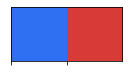

In [23]:
# I have created my own pallete to clearly convay risk in red and no risk in blue.
NoRisk_Risk = ["#2F70F2", "#D83A37"]
sns.set_palette(NoRisk_Risk)
sns.palplot(sns.color_palette())

### Count plots, stacked with label.

<AxesSubplot:title={'center':'Count of Risk/NoRisk'}, xlabel='label', ylabel='count'>

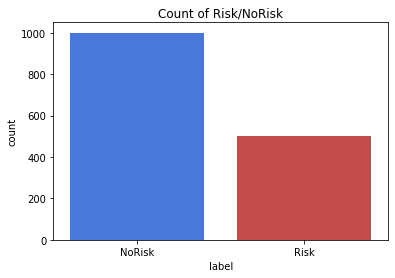

In [24]:
plt.title("Count of Risk/NoRisk")
sns.countplot(data=df_cvd_cleaned, x='label')

<AxesSubplot:xlabel='Diabetes'>

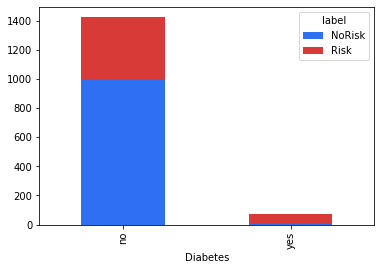

In [25]:
# plt.title("Count of Diabtese")
df_plot = df_cvd_cleaned.groupby(['label', 'Diabetes']).size().reset_index().pivot(columns='label', index='Diabetes', values=0)
df_plot.plot(kind='bar', stacked=True)
#sns.countplot(data=df_cvd_cleaned, x='Diabetes')

<AxesSubplot:xlabel='IHD'>

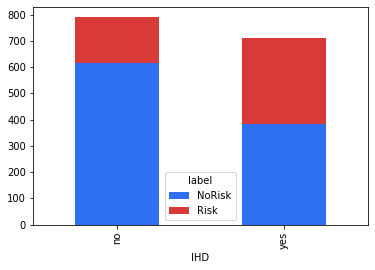

In [26]:
# plt.title("Count of IHD")
df_plot = df_cvd_cleaned.groupby(['label', 'IHD']).size().reset_index().pivot(columns='label', index='IHD', values=0)
df_plot.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Hypertension'>

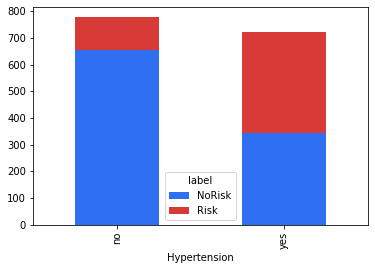

In [27]:
#plt.title("Count of Hypertension")
df_plot = df_cvd_cleaned.groupby(['label', 'Hypertension']).size().reset_index().pivot(columns='label', index='Hypertension', values=0)
df_plot.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Arrhythmia'>

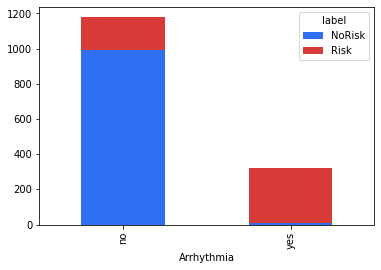

In [28]:
# plt.title("Count of Arrhythmia")
df_plot = df_cvd_cleaned.groupby(['label', 'Arrhythmia']).size().reset_index().pivot(columns='label', index='Arrhythmia', values=0)
df_plot.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='History'>

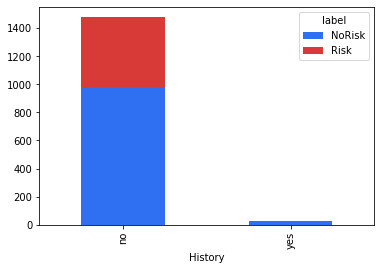

In [29]:
# plt.title("Count of History")
df_plot = df_cvd_cleaned.groupby(['label', 'History']).size().reset_index().pivot(columns='label', index='History', values=0)
df_plot.plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Indication'>

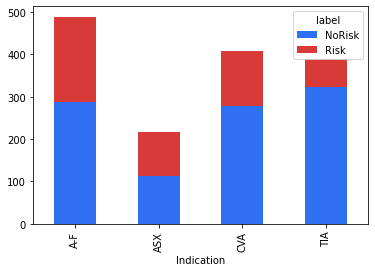

In [30]:
# plt.title("Count of Indication")
df_plot = df_cvd_cleaned.groupby(['label', 'Indication']).size().reset_index().pivot(columns='label', index='Indication', values=0)
df_plot.plot(kind='bar', stacked=True)

### Looking at IPSI and Contra

<AxesSubplot:title={'center':'IPSI vs Indication vs label'}, xlabel='Indication', ylabel='IPSI'>

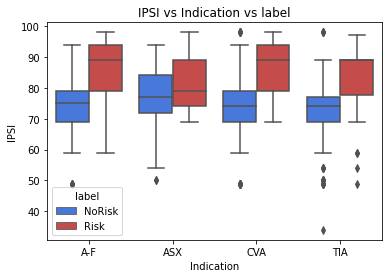

In [31]:
plt.title('IPSI vs Indication vs label')
sns.boxplot(data=df_cvd_cleaned, x='Indication', y='IPSI', hue='label')

<AxesSubplot:title={'center':'Contra vs Indication vs label'}, xlabel='Indication', ylabel='Contra'>

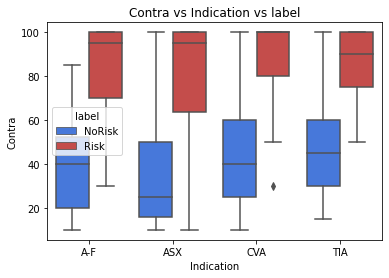

In [32]:
plt.title('Contra vs Indication vs label')
sns.boxplot(data=df_cvd_cleaned, x='Indication', y='Contra', hue='label')

<AxesSubplot:>

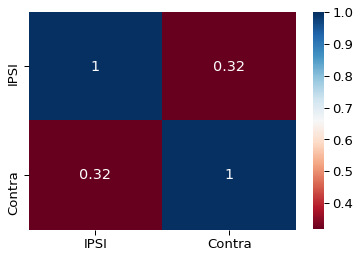

In [33]:
sns.set_context('paper', font_scale=1.5)

# Set up variables in a matrix formatt.
df_ipsi_contra = df_cvd_cleaned.drop(columns=['Random', 'Id', 'Indication', 'Diabetes', 'IHD', 'Hypertension', 'Arrhythmia', 'History', 'label'])
cvd_mx = df_ipsi_contra.corr() 

sns.heatmap(cvd_mx, annot=True, cmap='RdBu')
# Slightly possitevely correlated. 

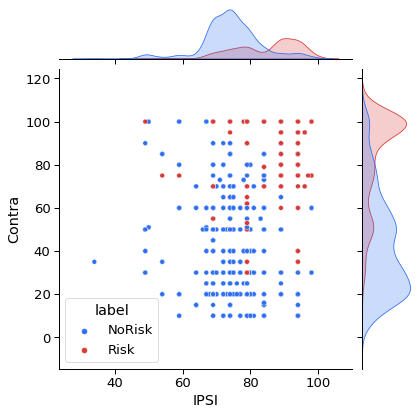

In [34]:
# Plotting IPSI against Contra, with the label being hue.
sns.set_context('paper', font_scale=1.5)
sns.jointplot(data=df_cvd_cleaned, x='IPSI', y='Contra', kind='scatter', hue='label')
# Strong possitive correlation between Contra and IPSI leading to Risk.

# Encoding data

In [35]:
# One-Hot Encoding Indication.
onehot_indication = pd.get_dummies(df_cvd_cleaned.Indication, prefix='Indication')
onehot_indication

,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0
...,...,...,...,...
1515,0,1,0,0
1516,0,0,1,0
1517,0,0,1,0
1518,0,0,0,1


In [36]:
# The following can be dummy variables.
dummy_diabetes = pd.get_dummies(df_cvd_cleaned.Diabetes, drop_first=True)
dummy_diabetes.rename(columns={'yes' : 'Diabetes'}, inplace=True)

In [37]:
dummy_ihd = pd.get_dummies(df_cvd_cleaned.IHD, drop_first=True)
dummy_ihd.rename(columns={'yes' : 'IHD'}, inplace=True)

In [38]:
dummy_hypertension = pd.get_dummies(df_cvd_cleaned.Hypertension, drop_first=True)
dummy_hypertension.rename(columns={'yes' : 'Hypertension'}, inplace=True)

In [39]:
dummy_arrhythmia = pd.get_dummies(df_cvd_cleaned.Arrhythmia, drop_first=True)
dummy_arrhythmia.rename(columns={'yes' : 'Arrhythmia'}, inplace=True)

In [40]:
dummy_history = pd.get_dummies(df_cvd_cleaned.History, drop_first=True)
dummy_history.rename(columns={'yes' : 'History'}, inplace=True)

In [41]:
dummy_label = pd.get_dummies(df_cvd_cleaned.label, drop_first=True)

## Feature Discretision - Chunking
Feature Discretisation helps reduce the search space. <br>
pd.cut allows us to create a new df and do some binning to the IPSI and Contra features. <br>

In [42]:
# Define bins and labels here as both features need to be chuncked the same to keep consistency.
bins_to_chunk = [0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94,99,100]
bin_labels = ['0', '5','10','15','20','25','30','35','40','45','50','55','60','65','70','75','80','85','90','95','100']

In [43]:
bin_ipsi = df_cvd_cleaned.IPSI
bin_ipsi = pd.cut(bin_ipsi, bins=bins_to_chunk, labels=bin_labels) # Bin Ipsilateral.
bin_ipsi.rename('IPSI_%', inplace=True) # Name the axis.
bin_ipsi = pd.to_numeric(bin_ipsi, downcast=('unsigned')) # Downcast for efficieny.
bin_ipsi.value_counts().sort_index() # Look at bins.

30      1
45     23
50     16
55     29
60     14
65    265
70    326
75    330
80    131
85    173
90    154
95     38
Name: IPSI_%, dtype: int64

In [44]:
print(bin_ipsi.isnull().sum()) # Check we havn't lost any data.

0


In [45]:
# Contra already follows this patern, but bining will reduce search space.
bin_contra = df_cvd_cleaned.Contra
bin_contra = pd.cut(bin_contra, bins=bins_to_chunk, labels=bin_labels) # Bin contralaterol.
bin_contra.rename('Contra_%', inplace=True) # Name the axis.
bin_contra = pd.to_numeric(bin_contra, downcast=('unsigned')) # Downcast for efficieny.
bin_contra.value_counts().sort_index() # Look at bins.

10      50
15      22
20     191
25      30
30     162
35      27
40     108
45       6
50     202
55      22
60     102
65      17
70      59
75      62
80      53
85      35
90      44
95      32
100    276
Name: Contra_%, dtype: int64

In [46]:
print(bin_contra.isnull().sum()) # Check we havn't lost any data.

0


## Amalagamate encoded features into a new df.
While getting our data ready for training, I'm also going to drop the random, and id columns as they don't hold relevant information for the model. Multiple sessions could hold a patern, they could show how early symptoms do develop into a high risk of CVD over time.

In [47]:
# drop old columns.
df_cvd_encoded_set_0 = df_cvd_cleaned.drop(columns=['Random', 'Id', 'Indication', 'Diabetes', 'IHD', 'Hypertension', 'Arrhythmia', 'History', 'IPSI', 'Contra', 'label'])
# concat new encoded columns.
df_cvd_encoded_set_0 = pd.concat([df_cvd_encoded_set_0, onehot_indication, dummy_diabetes, dummy_ihd, dummy_hypertension, dummy_arrhythmia, dummy_history, bin_ipsi, bin_contra, dummy_label], axis=1)
df_cvd_encoded_set_0

,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI_%,Contra_%,Risk
0,0,0,1,0,1,1,1,1,0,85,100,1
1,0,0,1,0,0,0,0,0,0,65,100,0
2,0,0,1,0,0,1,1,0,0,75,20,0
3,1,0,0,0,0,1,0,0,0,65,40,0
4,0,0,1,0,0,0,0,0,0,85,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1515,0,1,0,0,0,1,1,1,0,70,100,1
1516,0,0,1,0,0,1,1,0,0,80,50,0
1517,0,0,1,0,0,0,1,0,0,75,20,0
1518,0,0,0,1,0,0,1,1,0,75,35,0


### Now that the data is encoded, we can visualise some more patterns.

<AxesSubplot:title={'center':'Heatmap of all features'}>

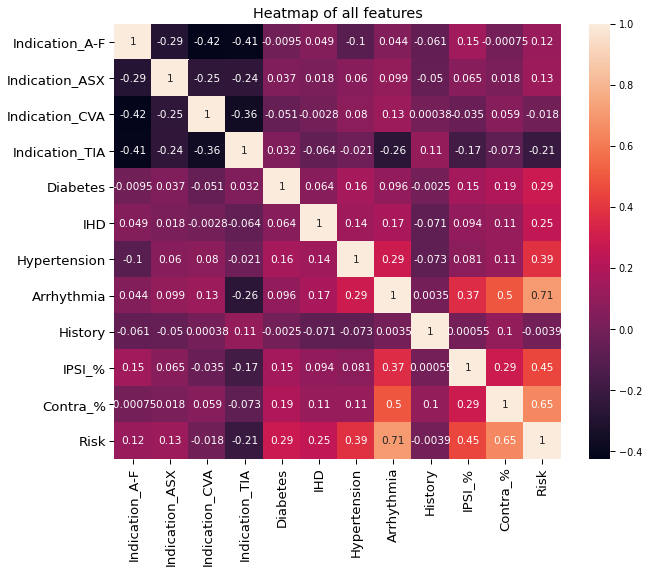

In [48]:
plt.figure(figsize=(10,8))
plt.title('Heatmap of all features')
sns.set_context('paper', font_scale=1.1)
sns.heatmap(data=df_cvd_encoded_set_0.corr(), annot=True)

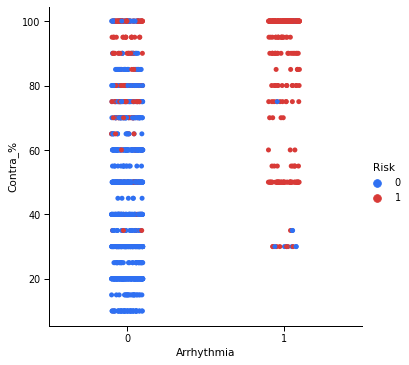

In [49]:
sns.catplot(data=df_cvd_encoded_set_0, x='Arrhythmia', y='Contra_%', hue='Risk')
# Identified possible outlier, there is a no risk data point that has high contra and arrhythmia.

In [50]:
# Unable to get selection to work, Contra_% is acting strange.
# df_cvd_encoded_set_0[(df_cvd_encoded_set_0.Arrhythmia == 1) & (df_cvd_encoded_set_0.Contra_% > 70)]

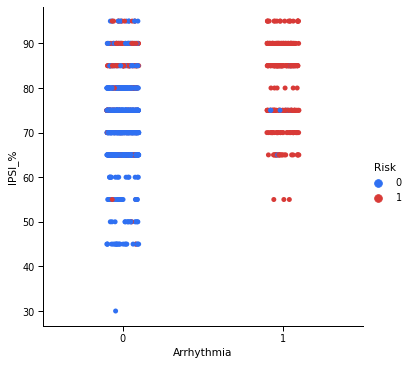

In [51]:
sns.catplot(data=df_cvd_encoded_set_0, x='Arrhythmia', y='IPSI_%', hue='Risk')

## Feature Selection
I am creating 3 new data sets based on learning what features can be dropped.

In [52]:
df_cvd_encoded_set_1 = df_cvd_encoded_set_0.drop(columns=['History'])
df_cvd_encoded_set_1.head(1)

,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA,Diabetes,IHD,Hypertension,Arrhythmia,IPSI_%,Contra_%,Risk
0,0,0,1,0,1,1,1,1,85,100,1


In [53]:
# Based off Set 1 that already has history dropped.
df_cvd_encoded_set_2 = df_cvd_encoded_set_1.drop(columns=['Indication_A-F', 'Indication_CVA'])
df_cvd_encoded_set_2.head(1)

,Indication_ASX,Indication_TIA,Diabetes,IHD,Hypertension,Arrhythmia,IPSI_%,Contra_%,Risk
0,0,0,1,1,1,1,85,100,1


In [54]:
# Based off Set 1 that already has history dropped.
# Set 3 added after Random Forrest feature importance.
df_cvd_encoded_set_3 = df_cvd_encoded_set_1.drop(columns=['Indication_ASX'])
df_cvd_encoded_set_3.head(1)

,Indication_A-F,Indication_CVA,Indication_TIA,Diabetes,IHD,Hypertension,Arrhythmia,IPSI_%,Contra_%,Risk
0,0,1,0,1,1,1,1,85,100,1


## Sanity checks

First I would like to manually look at a few entries and compare the raw data to the encoded data to ensure that the encoding has been done correctly. 

In [55]:
# Picked because of IPSI and Contra, wanted to ensure binning was correct. It initially wasn't.
df_cvd_encoded_set_0.loc[[922]] # A-F,no,no,yes,no,no,75.0,50 ,NoRisk

,Indication_A-F,Indication_ASX,Indication_CVA,Indication_TIA,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI_%,Contra_%,Risk
922,1,0,0,0,0,0,1,0,0,75,50,0


In [56]:
df_cvd_encoded_set_0.dtypes # Sanity check, ensure data is all numerical and ready for model training.

Indication_A-F    uint8
Indication_ASX    uint8
Indication_CVA    uint8
Indication_TIA    uint8
Diabetes          uint8
IHD               uint8
Hypertension      uint8
Arrhythmia        uint8
History           uint8
IPSI_%            uint8
Contra_%          uint8
Risk              uint8
dtype: object

In [57]:
print(df_cvd_encoded_set_0.isnull().sum()) # Sanity check, ensure there are no nulls.

Indication_A-F    0
Indication_ASX    0
Indication_CVA    0
Indication_TIA    0
Diabetes          0
IHD               0
Hypertension      0
Arrhythmia        0
History           0
IPSI_%            0
Contra_%          0
Risk              0
dtype: int64


# Modelling
## Split the data

Now our data is ready, we want to create our training and testing sets. <br>

Our truth, target value y, will be Risk, as that's what we want our model to predict. <br>

Our training data, inputs x, will be everything other than Risk. <br>

We split our data 70 / 30. We train on 70% of the data and then test on 30%.



In [58]:
# Change data sets here.
df_model_data = df_cvd_encoded_set_3

In [59]:
# Create target set Y - Risk.
y = df_model_data.Risk
y # is series, 1d.

0       1
1       0
2       0
3       0
4       0
       ..
1515    1
1516    0
1517    0
1518    0
1519    0
Name: Risk, Length: 1500, dtype: uint8

In [60]:
# Create training set x - Everything BUT Risk.
x = df_model_data.drop(columns=['Risk'])
x # is data frame, 2d.

,Indication_A-F,Indication_CVA,Indication_TIA,Diabetes,IHD,Hypertension,Arrhythmia,IPSI_%,Contra_%
0,0,1,0,1,1,1,1,85,100
1,0,1,0,0,0,0,0,65,100
2,0,1,0,0,1,1,0,75,20
3,1,0,0,0,1,0,0,65,40
4,0,1,0,0,0,0,0,85,30
...,...,...,...,...,...,...,...,...,...
1515,0,0,0,0,1,1,1,70,100
1516,0,1,0,0,1,1,0,80,50
1517,0,1,0,0,0,1,0,75,20
1518,0,0,1,0,0,1,1,75,35


In [61]:
# Split the data.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

## Multi Layer Perceptron (MLP) classifier.

Now that we have our data sets split, we can pass it to our model for training. <br>

In [62]:
# Create the MLP model.
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

# model = MLPClassifier(hidden_layer_sizes=(11,14,2), max_iter=1000, activation='relu', solver='sgd', learning_rate='adaptive') # MLP 1
# model = MLPClassifier(hidden_layer_sizes=(11,14,2), max_iter=1000, activation='identity', solver='lbfgs') # MLP 2,3,4,5
model = MLPClassifier(hidden_layer_sizes=(11,14,2), max_iter=1000, activation='tanh', solver='adam', batch_size=500, beta_1=0.8, beta_2=0.75) # MLP 6 

model.fit(x_train,y_train) # Training - Fit our data to the model.

pred_y = model.predict(x_test) # Predict. 

accuracy_score(y_test, pred_y, normalize=True)

0.9711111111111111

## Evaluation metrics - Confusion matrix and F2 score

In [63]:
mean_squared_error(y_train, model.predict(x_train))

0.023809523809523808

In [64]:
mean_absolute_error(y_train, model.predict(x_train))

3.894285714285714

In [65]:
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       302
           1       0.96      0.95      0.96       148

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450



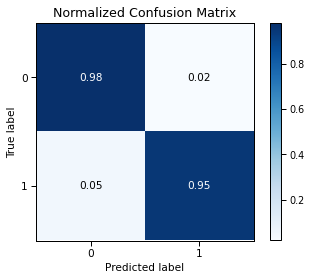

In [66]:
# We used our model to predict (x_test) above, now we are comparing that with the truth (y_test).
sns_plot = skplt.metrics.plot_confusion_matrix(y_test, pred_y, normalize=True) 
sns_plot.figure.savefig("Second model.png") # Save it as we will go through and change some things.

# Random Forest Classifier
https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56


In [67]:
# Create a list to label the feature importance.
# Need to make df with labels for each of the 4 different data sets otherwise they don't match up.
df_cvd_feature_names_set_0 = ['Indication A-F', 'Indication ASX', 'Indication CVA', 'Indication TIA', 'Diabetes', 'IHD', 'Hypertension', 'Arrhythmia', 'History', 'IPSI', 'Contra']

df_cvd_feature_names_set_3 = ['Indication A-F', 'Indication CVA', 'Indication TIA', 'Diabetes', 'IHD', 'Hypertension', 'Arrhythmia', 'IPSI', 'Contra']

In [68]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini')
rf.fit( x_train, y_train ) # Use the same split data as above.
y_pred_test = rf.predict(x_test) # Predict using random forrest.
rf.score( x_test, y_test ) # View accuracy score 

0.9777777777777777

In [69]:
print(classification_report(y_test, y_pred_test)) # View the classification report for test data and predictions

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       302
           1       0.95      0.98      0.97       148

    accuracy                           0.98       450
   macro avg       0.97      0.98      0.97       450
weighted avg       0.98      0.98      0.98       450



In [70]:
# Print out the feature importance, labeled.
# Only working for data set 0 atm.
for name, score in zip( df_cvd_feature_names_set_3, rf.feature_importances_ ):
    print(name, score)
# From this I can see that ASX and History have low importance.

Indication A-F 0.02010952795814899
Indication CVA 0.014713576159616337
Indication TIA 0.01882392275851524
Diabetes 0.03174194163932522
IHD 0.045783557405746904
Hypertension 0.0784431650480538
Arrhythmia 0.28323670117698485
IPSI 0.17327689759702647
Contra 0.33387071025658216


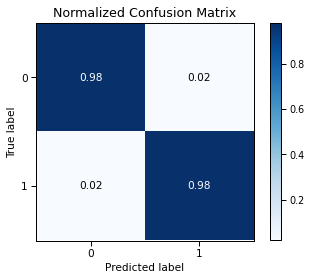

In [71]:
sns_plot = skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True) 